In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import time
import matplotlib.pyplot as plt
import copy
from torchvision.transforms import InterpolationMode
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import gc
import re
import random
from torchsummary import summary
import torchvision.models as models 

Reproducibility Helpers

In [2]:
def set_seed(seed: int = 42):
    """Sets seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Seeds set to {seed}")


# --- DataLoader Worker Initialization (if num_workers > 0) ---
def seed_worker(worker_id):
    """Ensures worker subprocesses are also seeded."""
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

Dataset- returns input image and float32 count.

In [3]:
class CellCountDataset(Dataset):
    def __init__(self, input_folder, labels_folder,
                input_transform=None, label_base_transform=None):
        """
        Args:
            input_folder (str): Path to the folder containing input images.
            labels_folder (str): Path to the folder containing label images
                                (e.g., '...XXXdots.png').
            input_transform (callable, optional): Optional transform to be
                                                applied to the input image.
            label_base_transform (callable, optional): Optional transform applied
                                    to the label image *before* counting.
                                    Should typically include ToTensor().
                                    Avoid normalization or augmentations here
                                    that would disrupt pixel value counting.
        """
        super().__init__()
        self.input_folder = input_folder
        self.labels_folder = labels_folder
        self.input_transform = input_transform
        # Basic transform for labels just to get tensor for counting
        self.label_transform = label_base_transform if label_base_transform else transforms.ToTensor()

        self.image_files = sorted([
            f for f in os.listdir(input_folder)
            if f.lower().endswith((".png", ".jpeg", ".jpg"))
        ])

        # --- Pre-match input and label files for efficiency and error checking ---
        self.file_pairs = []
        label_files_available = {
            f for f in os.listdir(labels_folder)
            if f.lower().endswith((".png", ".jpeg", ".jpg"))
        }

        missing_labels = []
        for inp_filename in self.image_files:
            # Extract the 3-digit ID (adjust regex if needed)
            match = re.search(r'(\d{3})(?=cell)', inp_filename) # Assumes format like '...XXXcell...'
            if not match:
                print(f"Warning: Could not extract ID from input file: {inp_filename}")
                continue
            digits = match.group(1)

            # Construct the expected label filename
            expected_label_filename = f"{digits}dots.png" # Adjust if label naming differs

            # Check if the label file exists
            if expected_label_filename in label_files_available:
                inp_path = os.path.join(self.input_folder, inp_filename)
                lbl_path = os.path.join(self.labels_folder, expected_label_filename)
                self.file_pairs.append({"input": inp_path, "label": lbl_path})
            else:
                missing_labels.append(inp_filename)

        if missing_labels:
            print(f"Warning: Could not find matching labels for {len(missing_labels)} input files:")
            # for fname in missing_labels[:10]: # Print first few missing
            #     print(f"  - {fname}")

        print(f"Found {len(self.file_pairs)} matching input/label image pairs.")
        # --- End of pre-matching ---


    def __len__(self):
        """Returns the number of matched input/label pairs."""
        return len(self.file_pairs)

    def __getitem__(self, idx):
        """
        Gets the input image and its corresponding cell count.
        """
        if idx >= len(self.file_pairs):
            raise IndexError("Index out of bounds")

        pair_info = self.file_pairs[idx]
        inp_path = pair_info["input"]
        lbl_path = pair_info["label"]

        try:
            # Load input image
            inp_img = Image.open(inp_path).convert('RGB') # Ensure 3 channels for consistency

            # Load label image (only needed for counting)
            lbl_img = Image.open(lbl_path)

            # Apply necessary transform to label to convert to tensor for counting
            lbl_tensor = self.label_transform(lbl_img)

            # --- Count non-zero pixels in the first channel ---
            # Assumes:
            # 1. label_transform includes ToTensor()
            # 2. Label dots are marked primarily in the Red channel (channel 0)
            # 3. Background is black (or has 0 in the Red channel)

            if lbl_tensor.dim() == 3 and lbl_tensor.shape[0] >= 1: # Check if it's a multi-channel tensor (e.g., 3xHxW)
                r_channel = lbl_tensor[0]
            elif lbl_tensor.dim() == 2: # Check if it's grayscale (HxW)
                r_channel = lbl_tensor
            else:
                raise ValueError(f"Unexpected label tensor shape: {lbl_tensor.shape} for {lbl_path}")

            count = torch.count_nonzero(r_channel).float() # float32 count
            # --- End of count calculation ---

            # Apply input transforms (including augmentations)
            if self.input_transform:
                inp_img = self.input_transform(inp_img) # Apply full transforms to input

            return inp_img, count # Return only input image and count

        except FileNotFoundError as e:
            print(f"Error loading file: {e}")
            raise e
        except Exception as e:
            print(f"Error processing index {idx} (Input: {inp_path}, Label: {lbl_path}): {e}")
            raise e

Training Function

In [4]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, dataset_sizes, device,
                mae_metric, model_save_path, plot_save_path=None, num_epochs=10):
    """
    Trains a PyTorch model, saves the best weights, and plots metrics.

    Args:
        model (torch.nn.Module): The neural network model to train.
        dataloaders (dict): Dictionary containing DataLoaders for 'train' and 'val'.
        criterion (torch.nn.Module): The loss function (e.g., MSELoss, L1Loss).
        optimizer (torch.optim.Optimizer): The optimization algorithm (e.g., Adam, SGD).
        scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler.
        dataset_sizes (dict): Dictionary mapping 'train'/'val' to dataset size.
        device (torch.device): The device to run training on (CPU or CUDA).
        mae_metric (callable): Function that takes predictions and targets (tensors)
                               and returns the Mean Absolute Error (scalar tensor).
        model_save_path (str): Path (including filename, e.g., 'best_model.pth')
                               to save the best model weights.
        plot_save_path (str, optional): Path (including filename, e.g., 'training_plot.png')
                                        to save the plot image. If None, plot is only shown.
        num_epochs (int): Total number of epochs to train for.

    Returns:
        tuple: (trained_model, history)
            - model (torch.nn.Module): Model with weights loaded from the best epoch.
            - history (dict): Dictionary containing training and validation loss
                              and MAE history for each epoch.
    """
    start_time = time.time()

    # Ensure model is on the correct device
    model.to(device)

    # Keep track of the best model weights found so far based on validation MAE
    best_model_wts = copy.deepcopy(model.state_dict())
    best_mae = float('inf') # Initialize best MAE to infinity

    # Dictionary to store training history
    history = {'train_loss': [], 'val_loss': [], 'train_mae': [], 'val_mae': []}

    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch}/{num_epochs-1}\n" + "-"*10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_mae = 0.0

            # Iterate over data.
            for inputs, counts in dataloaders[phase]:
                inputs = inputs.to(device)
                counts = counts.to(device).float() # Ensure counts are float

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                # Track history only in train phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # Ensure output shape matches target shape for loss/metric
                    outputs_squeezed = outputs.squeeze()

                    # --- Calculate Loss ---
                    loss = criterion(outputs_squeezed, counts)

                    # --- Calculate MAE ---
                    mae = mae_metric(outputs_squeezed, counts)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                batch_size = inputs.size(0)
                running_loss += loss.item() * batch_size
                running_mae += mae.item() * batch_size

            # Calculate epoch statistics using dataset_sizes
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_mae = running_mae / dataset_sizes[phase]

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} MAE: {epoch_mae:.4f}')

            # Store history
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_mae'].append(epoch_mae)

            # --- Scheduler Step ---
            if phase == 'train':
                 if not isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                     scheduler.step()
            elif phase == 'val':
                 if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                     scheduler.step(epoch_mae) # Step using validation MAE

                 # --- Save Best Model ---
                 if epoch_mae < best_mae:
                     best_mae = epoch_mae
                     best_model_wts = copy.deepcopy(model.state_dict())
                     # --- Save the best model weights locally ---
                     try:
                         print(f'    New best validation MAE: {best_mae:.4f} -> Saving model weights.')
                         torch.save(best_model_wts, model_save_path)
                     except Exception as e:
                         print(f"    Error saving model: {e}")
                     # -------------------------------------------

        print() # Newline after each epoch's train/val phases

    # Calculate training time
    time_elapsed = time.time() - start_time
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best Validation MAE: {best_mae:.4f}')

    # --- Plotting ---
    print("Generating plots...")
    epochs = range(num_epochs)
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_mae'], label='Train MAE')
    plt.plot(epochs, history['val_mae'], label='Val MAE')
    # Highlight the best validation MAE epoch
    best_epoch = np.argmin(history['val_mae'])
    plt.scatter(best_epoch, best_mae, s=100, c='red', marker='*', label=f'Best Val MAE: {best_mae:.4f}')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE (L1)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    # Save the plot if path provided
    if plot_save_path:
        try:
            plt.savefig(plot_save_path)
            print(f"Plot saved to {plot_save_path}")
        except Exception as e:
            print(f"Error saving plot: {e}")

    plt.show() # Display the plot

    # Load best model weights before returning
    print(f"Loading best model weights (Val MAE: {best_mae:.4f}) before returning.")
    model.load_state_dict(best_model_wts)
    return model, history

Simple CNN

In [5]:
class SimpleConvCounter(nn.Module):
    def __init__(self, input_channels=1, initial_filters=32, dropout_prob=0.0): # Default input_channels=1 now
        """
        A simple CNN for cell counting (regression).

        Args:
            input_channels (int): Number of channels in the input image (e.g., 1 for Blue).
            initial_filters (int): Number of filters in the first convolutional layer.
            dropout_prob (float): Probability for dropout layer (0 to disable).
        """
        super().__init__()
        print(f"Initializing SimpleConvCounter with input_channels={input_channels}, initial_filters={initial_filters}")

        # --- Feature Extraction (Convolutional Blocks) ---
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(input_channels, initial_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(initial_filters),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(initial_filters, initial_filters * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(initial_filters * 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(initial_filters * 2, initial_filters * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(initial_filters * 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(initial_filters * 4, initial_filters * 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(initial_filters * 8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # --- Adaptive Pooling ---
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        # --- Regression Head (Fully Connected Layers) ---
        fc_input_features = initial_filters * 8
        layers = []
        layers.append(nn.Linear(fc_input_features, 128))
        layers.append(nn.ReLU(inplace=True))
        if dropout_prob > 0:
             print(f"Adding Dropout layer with p={dropout_prob}")
             layers.append(nn.Dropout(p=dropout_prob))
        layers.append(nn.Linear(128, 1))
        self.fc_head = nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc_head(x)
        return x

Helper to select only the blue channel

In [6]:
def select_blue_channel(x):
    """Selects the blue channel (index 2) from a CHW tensor and keeps dim."""
    # Input x is expected to be CHW tensor from ToTensor()
    return x[2:3, :, :]

Main Code

Seeds set to 42
Using device: cuda:0
Defining transforms for single blue channel (unnormalized)...
Creating datasets using single blue channel unnormalized transforms...
Found 180 matching input/label image pairs.
Found 20 matching input/label image pairs.
Creating dataloaders with batch_size=32, num_workers=0...
Instantiating model for single channel input (initial_filters=32)...
Initializing SimpleConvCounter with input_channels=1, initial_filters=32
Starting training with single blue channel (unnormalized + flips)...
Starting training for 130 epochs...

Epoch 0/129
----------
Train Loss: 34345.0896 MAE: 175.1907
Val Loss: 33172.6367 MAE: 169.9234
    New best validation MAE: 169.9234 -> Saving model weights.


Epoch 1/129
----------
Train Loss: 32802.0361 MAE: 171.0053
Val Loss: 32640.7129 MAE: 168.3591
    New best validation MAE: 168.3591 -> Saving model weights.


Epoch 2/129
----------
Train Loss: 30554.6959 MAE: 164.6063
Val Loss: 31794.8789 MAE: 165.9139
    New best validatio

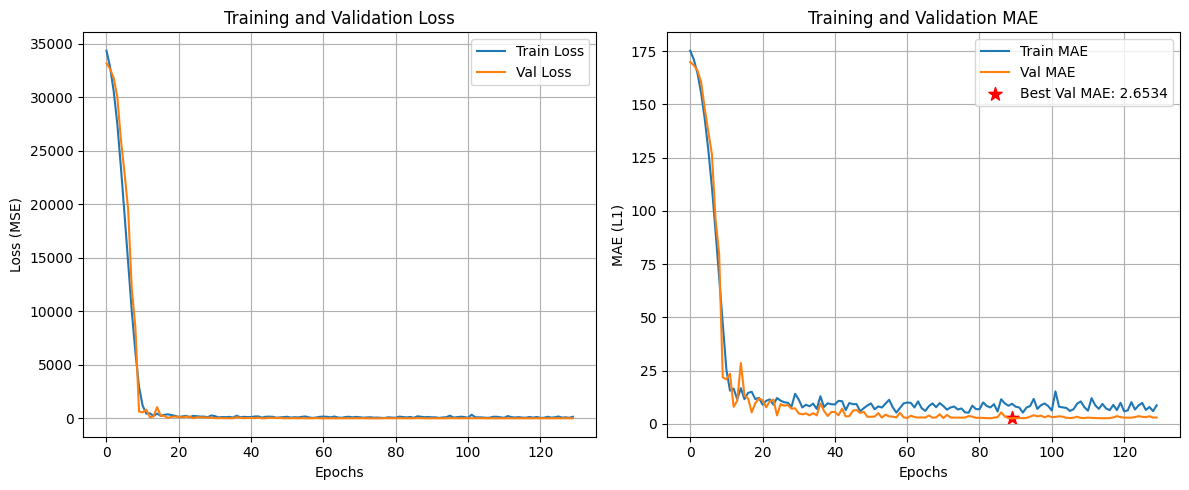

Loading best model weights (Val MAE: 2.6534) before returning.


In [7]:
SEED = 42
set_seed(SEED) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Paths ---
train_folder = r'C:\Users\goldy\OneDrive\Documents\Y-DATA 24-25\Homework\DL\HW 5\counting_cells_data\train_images'
train_labels_folder = r'C:\Users\goldy\OneDrive\Documents\Y-DATA 24-25\Homework\DL\HW 5\counting_cells_data\train_labels'
val_folder = r'C:\Users\goldy\OneDrive\Documents\Y-DATA 24-25\Homework\DL\HW 5\counting_cells_data\val_images'
val_label_folder = r'C:\Users\goldy\OneDrive\Documents\Y-DATA 24-25\Homework\DL\HW 5\counting_cells_data\val_labels'

# --- Define Transforms for Single Blue Channel (NO NORMALIZATION) ---
print("Defining transforms for single blue channel (unnormalized)...")
train_transform_blue_unnorm = transforms.Compose([
    # --- Add Mild Augmentations (Flips Only) ---
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # -------------------------------------------
    transforms.ToTensor(),       # Converts PIL HWC [0-255] to PyTorch CHW [0-1]
    select_blue_channel,         # Use the named function here
    # NO transforms.Normalize HERE
])

val_transform_blue_unnorm = transforms.Compose([
    transforms.ToTensor(),
    select_blue_channel,         # Use the named function here
    # NO transforms.Normalize HERE
])

# Label transform remains the same
train_label_transform = transforms.Compose([
    transforms.ToTensor()
])

# --- Create Datasets with Blue Channel Unnormalized Transforms ---
print("Creating datasets using single blue channel unnormalized transforms...")
train_dataset = CellCountDataset(
    train_folder, train_labels_folder,
    input_transform=train_transform_blue_unnorm, # Use blue unnorm transform
    label_base_transform=train_label_transform
)
val_dataset = CellCountDataset(
    val_folder, val_label_folder,
    input_transform=val_transform_blue_unnorm, # Use blue unnorm transform
    label_base_transform=train_label_transform
)

# --- Create DataLoaders ---
batch_size = 32
num_workers = 0 #changed from 4 
print(f"Creating dataloaders with batch_size={batch_size}, num_workers={num_workers}...")
dataloaders = {
    'train': DataLoader(
        train_dataset, # Use blue unnorm dataset
        batch_size=batch_size, shuffle=True, pin_memory=torch.cuda.is_available(), num_workers=num_workers,
        worker_init_fn=seed_worker if num_workers > 0 else None
        ),

    'val': DataLoader(
        val_dataset, # Use blue unnorm dataset
        batch_size=batch_size, shuffle=False, pin_memory=torch.cuda.is_available(), num_workers=num_workers,
        worker_init_fn=seed_worker if num_workers > 0 else None
        )
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# --- Instantiate Model for Single Channel Input ---
print("Instantiating model for single channel input (initial_filters=32)...")
model = SimpleConvCounter(input_channels=1, initial_filters=32, dropout_prob=0.0).to(device) # input_channels=1

# --- Define Criterion, Optimizer, Scheduler (from best run) ---
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
mae_metric = nn.L1Loss()

# --- Define save paths ---
SAVE_DIR = './results_blue_unnorm_flips' # New directory
os.makedirs(SAVE_DIR, exist_ok=True)
model_path = os.path.join(SAVE_DIR, 'best_model_blue_unnorm_flips.pth')
plot_path = os.path.join(SAVE_DIR, 'training_curves_blue_unnorm_flips.png')

# --- Train the Model ---
print("Starting training with single blue channel (unnormalized + flips)...")
trained_model, training_history = train_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    scheduler,
    dataset_sizes,
    device,
    mae_metric,
    model_save_path=model_path,
    plot_save_path=plot_path,
    num_epochs=130 
)